<a href="https://colab.research.google.com/github/ChristianJFG/Portfolio-GitHub/blob/main/lacI_titration_bayesian_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import library to handle operating system
import os

# Import numerical workhorse
import numpy as np

# Import library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Import library for interactive widgets
import panel as pn

# Import library to handle data
import pandas as pd

# Import library to find files
import glob

# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/drive')

# Activate interactive widgets
pn.extension()

# Set plotting style
sns.set()

Mounted at /content/drive


# Load data into memory and visualize results

In [ ]:
# Define data directory
data_dir = "/content/drive/MyDrive/CdeC/PBoC_online/lacI_titration/"

# Load CSV file
df = pd.read_csv(data_dir + "image_processing_data.csv")

df.head()

,area,fluor,operator,rep,fluor_area,intensity,fold_change,rep_num
0,130.0,19792.0,O1,R124,152.246154,15.353312,0.007020,124
1,23.0,3251.0,O1,R124,141.347826,4.454984,0.002037,124
2,24.0,2978.0,O1,R124,124.083333,-12.809509,-0.005857,124
3,90.0,12137.0,O1,R124,134.855556,-2.037286,-0.000931,124
4,133.0,18132.0,O1,R124,136.330827,-0.562015,-0.000257,124


Text(0, 0.5, 'fold-change')

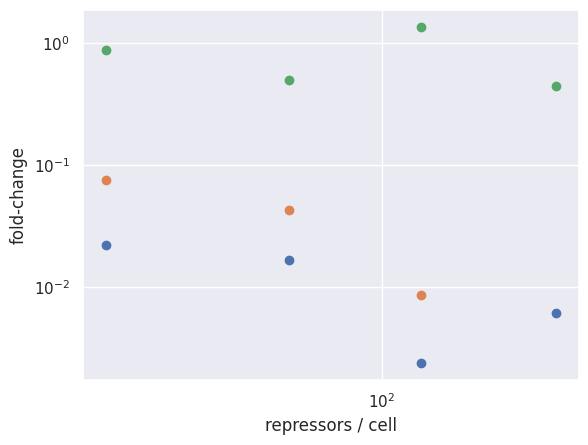

In [ ]:
# Initialize figure
fig, ax = plt.subplots(1, 1)

# Define colors for each operator
op_color = {
    "O1": sns.color_palette()[0],
    "O2": sns.color_palette()[1],
    "O3": sns.color_palette()[2],
}

# Group by operator & repressor
df_group = df.groupby(["operator", "rep_num"])

# Loop through each group
for ((op, rep), data) in df_group:
  # Plot rep vs <fold-change>
  ax.scatter(rep, data.fold_change.mean(), color=op_color[op], label=op)

# Make axis log-scale
ax.set_yscale("log")
ax.set_xscale("log")

# Label axis
ax.set_xlabel("repressors / cell")
ax.set_ylabel("fold-change")

Define function to compute log-fold-change from our stat. mech. derivation

In [ ]:
def log_fc(delta_eps, R, Nns=5E6):
  '''
  Function to compute the log-fold-chage in gene
  expression for a simple repression motif.

  Arguments
  ---------
  - `delta_eps`: Repressor binding energy in units of kBT.
  - `R`: Repressor copy number per cell.

  Optional Arguments
  ------------------
  - `Nns=5E6`: Number of non-specific binding sites
  '''
  # Compute the fold-change
  fc = 1 / (1 + R / Nns * np.exp(-delta_eps))

  # Return log-fold-change
  return np.log(fc)

Plot example curve of log-fold-change

Text(0, 0.5, 'log-fold-change')

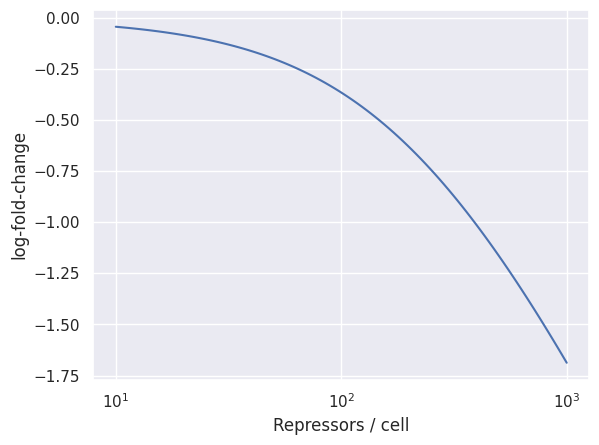

In [ ]:
# Define range of repressors to evaluate
R_range = np.logspace(1, 3, 100)

# Define binding energy
delta_eps = - 10 # kBT

# Evaulate log-fold-change
lfc = log_fc(delta_eps, R_range)

# Initialize figure
fig, ax = plt.subplots(1, 1)

# Plot R vs log fold-change
ax.plot(R_range, lfc)

# Set x-axis in log-scale
ax.set_xscale("log")

# Label axis
ax.set_xlabel("Repressors / cell")
ax.set_ylabel("log-fold-change")

In [ ]:
df.head(5)

,area,fluor,operator,rep,fluor_area,intensity,fold_change,rep_num
0,130.0,19792.0,O1,R124,152.246154,15.353312,0.007020,124
1,23.0,3251.0,O1,R124,141.347826,4.454984,0.002037,124
2,24.0,2978.0,O1,R124,124.083333,-12.809509,-0.005857,124
3,90.0,12137.0,O1,R124,134.855556,-2.037286,-0.000931,124
4,133.0,18132.0,O1,R124,136.330827,-0.562015,-0.000257,124


In [ ]:
# Group data by operator and repressor copy number
df_group = df.groupby(["operator", "rep_num"])

# Compute mean fold-change for each group
fc_mean = df_group["fold_change"].mean()

fc_mean

operator  rep_num
O1        0          0.377598
          22         0.022109
          60         0.016728
          124        0.002413
          260        0.006109
O2        0          0.539443
          22         0.075746
          60         0.043321
          124        0.008634
          260       -0.002160
O3        0          0.456770
          22         0.874597
          60         0.500174
          124        1.359362
          260        0.446057
Name: fold_change, dtype: float64

In [ ]:
type(fc_mean)

pandas.core.series.Series

Define function to compute log posterior

In [ ]:
def log_posterior(delta_eps, op, data):
  '''
  Function to compute the log posterior
  log π(delta_eps | D)

  Arguments
  ---------
  - `delta_eps`: Repressor binding energy.
  - `op`: String defining the operator site.
  - `data`: Pandas Series with the mean fold-change for
  each operator and each repressor copy number
  '''
  # Extract repressor copy numbers
  R = data[op].keys()

  # Extract log-fc-experiment
  lfc_exp = np.log(data[op].values)

  # Compute log-fc-theory
  lfc_theory = log_fc(delta_eps, R)

  # Comput log posterior
  log_post = - len(R) / 2 * np.log(np.sum((lfc_exp - lfc_theory)**2))

  return log_post

Compute log posterior for operators

Text(0, 0.5, 'π(∆eps | data)')

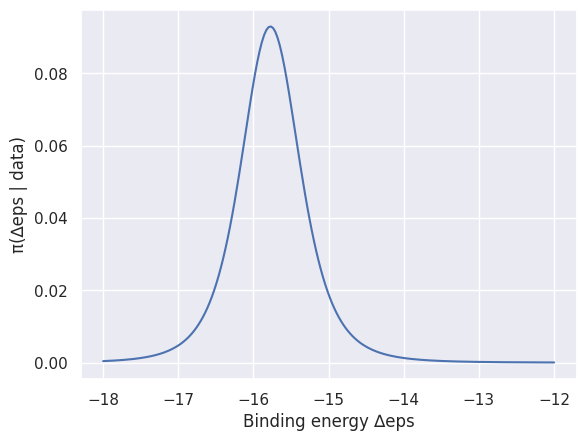

In [ ]:
# Define range of binding energies to evaluate
delta_eps_range = np.linspace(-18, -12, 200)

# Evaluate log posterior for each binding energy
log_post = [log_posterior(x, "O1", fc_mean) for x in delta_eps_range]

# Plot posterior distribution

# Initialize plot
fig, ax = plt.subplots(1, 1)

# Plot posterior
ax.plot(delta_eps_range, np.exp(log_post))

ax.set_xlabel("Binding energy ∆eps")
ax.set_ylabel("π(∆eps | data)")